In [1]:
"""
In this tutorial, we demonstrate gradient accumulation — a technique used to simulate a larger effective batch size
by accumulating gradients over several mini-batches before updating the model parameters. This is especially useful
when GPU memory is limited. We also explain why we scale the loss and how the accumulation helps.
"""


'\nIn this tutorial, we demonstrate gradient accumulation — a technique used to simulate a larger effective batch size\nby accumulating gradients over several mini-batches before updating the model parameters. This is especially useful\nwhen GPU memory is limited. We also explain why we scale the loss and how the accumulation helps.\n'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# For reproducibility
torch.manual_seed(42)


In [3]:
# We'll generate a synthetic regression dataset where the true relationship is:
#   y = 2.0 * x + 1.0, with added noise.
N = 100  # Total number of samples
X = torch.randn(N, 10)  # 100 samples, 10 features each
true_w = torch.randn(10, 1)
true_b = 1.0
y = X @ true_w + true_b + 0.1 * torch.randn(N, 1)  # Linear relationship with noise

# Create a DataLoader to simulate mini-batches
batch_size = 8  # Mini-batch size
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [4]:
model = nn.Linear(10, 1)  # A simple linear model for regression
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.SGD(model.parameters(), lr=0.01)


In [5]:
accumulations = 2  # Number of mini-batches over which to accumulate gradients


In [6]:
n_epochs = 20
training_losses = []

print("=== Starting Training with Gradient Accumulation ===")
for epoch in range(n_epochs):
    epoch_loss = 0.0
    # Note: We zero the gradients only at the beginning of the epoch.
    optimizer.zero_grad()
    
    # Loop over mini-batches from the DataLoader
    for idx, (data, target) in enumerate(train_loader):
        outputs = model(data)
        loss = criterion(outputs, target)
        
        # Scale the loss by the accumulation factor so that the gradient magnitude remains similar
        loss = loss / accumulations
        
        # Backward pass: accumulate gradients over several mini-batches
        loss.backward()
        epoch_loss += loss.item()
        
        # If the number of mini-batches processed is divisible by the accumulation factor,
        # update the parameters and zero the gradients.
        if (idx + 1) % accumulations == 0 or (idx + 1) == len(train_loader):
            optimizer.step()       # Update parameters based on the accumulated gradients
            optimizer.zero_grad()  # Reset gradients for the next accumulation cycle
    
    avg_loss = epoch_loss / len(train_loader)
    training_losses.append(avg_loss)
    print(f"Epoch {epoch+1:2d}/{n_epochs}, Average Loss: {avg_loss:.4f}")


=== Starting Training with Gradient Accumulation ===
Epoch  1/20, Average Loss: 9.1248
Epoch  2/20, Average Loss: 7.4536
Epoch  3/20, Average Loss: 4.9868
Epoch  4/20, Average Loss: 3.8560
Epoch  5/20, Average Loss: 2.8585
Epoch  6/20, Average Loss: 2.2032
Epoch  7/20, Average Loss: 1.7221
Epoch  8/20, Average Loss: 1.3496
Epoch  9/20, Average Loss: 1.1291
Epoch 10/20, Average Loss: 0.8789
Epoch 11/20, Average Loss: 0.6595
Epoch 12/20, Average Loss: 0.5444
Epoch 13/20, Average Loss: 0.4291
Epoch 14/20, Average Loss: 0.3732
Epoch 15/20, Average Loss: 0.2916
Epoch 16/20, Average Loss: 0.2166
Epoch 17/20, Average Loss: 0.1780
Epoch 18/20, Average Loss: 0.1508
Epoch 19/20, Average Loss: 0.1233
Epoch 20/20, Average Loss: 0.0983


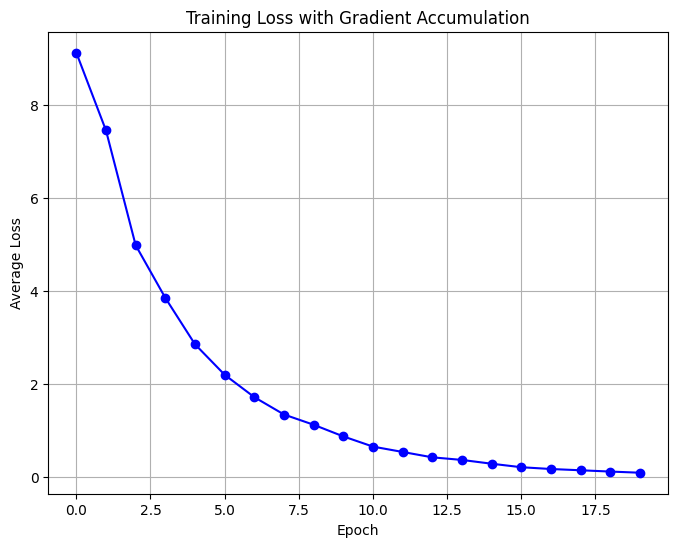

"\nExplanation:\n- We divide the loss by the number of accumulation steps to maintain the gradient scale.\n- Gradients are accumulated over 'accumulations' mini-batches.\n- We update the model parameters only when we've accumulated gradients from the specified number of mini-batches.\n- If we did not call optimizer.zero_grad() after each accumulation cycle,\n  the gradients would accumulate across epochs, leading to incorrect parameter updates.\n"

In [7]:
plt.figure(figsize=(8,6))
plt.plot(training_losses, marker='o', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss with Gradient Accumulation")
plt.grid(True)
plt.show()

"""
Explanation:
- We divide the loss by the number of accumulation steps to maintain the gradient scale.
- Gradients are accumulated over 'accumulations' mini-batches.
- We update the model parameters only when we've accumulated gradients from the specified number of mini-batches.
- If we did not call optimizer.zero_grad() after each accumulation cycle,
  the gradients would accumulate across epochs, leading to incorrect parameter updates.
"""


In [8]:
"""
If we did not use optimizer.zero_grad():
    - Gradients from multiple mini-batches would be summed up continuously, potentially
      leading to very large gradient values and causing unstable or divergent updates.

If we did not use 'torch.no_grad()' during evaluation (not shown here but common during inference):
    - PyTorch would build a computation graph for validation data, which increases memory usage
      and can inadvertently affect gradient accumulation if backward is mistakenly called on validation loss.

If we did not use unsqueeze (when needed for a model expecting 2D inputs):
    - The model might throw a shape mismatch error because nn.Linear expects an input
      of shape [batch_size, num_features] rather than a 1D tensor.
      
This example follows the principle of gradient accumulation:
1. We divide the loss by 'accumulations' to keep the gradient scale consistent.
2. We call loss.backward() for each mini-batch, accumulating gradients.
3. We update parameters and zero gradients only after processing 'accumulations' mini-batches.
"""

# End of Script

"\nIf we did not use optimizer.zero_grad():\n    - Gradients from multiple mini-batches would be summed up continuously, potentially\n      leading to very large gradient values and causing unstable or divergent updates.\n\nIf we did not use 'torch.no_grad()' during evaluation (not shown here but common during inference):\n    - PyTorch would build a computation graph for validation data, which increases memory usage\n      and can inadvertently affect gradient accumulation if backward is mistakenly called on validation loss.\n\nIf we did not use unsqueeze (when needed for a model expecting 2D inputs):\n    - The model might throw a shape mismatch error because nn.Linear expects an input\n      of shape [batch_size, num_features] rather than a 1D tensor.\n      \nThis example follows the principle of gradient accumulation:\n1. We divide the loss by 'accumulations' to keep the gradient scale consistent.\n2. We call loss.backward() for each mini-batch, accumulating gradients.\n3. We upda

In [9]:
# Example without zero_grad() and without accumulation, then compare outcomes.

# 1) Training without zero_grad(): gradients will accumulate across mini-batches and epochs.
model_no_zero_grad = nn.Linear(10, 1)
optimizer_no_zero_grad = optim.SGD(model_no_zero_grad.parameters(), lr=0.01)
training_losses_no_zero_grad = []

epochs_no_zero_grad = 5
print("=== Training WITHOUT zero_grad() ===")
for epoch_i in range(epochs_no_zero_grad):
    epoch_loss_no_zero = 0.0
    # We do NOT call optimizer_no_zero_grad.zero_grad() anywhere to demonstrate accumulation
    for data_batch, target_batch in train_loader:
        outputs_no_zero = model_no_zero_grad(data_batch)
        loss_no_zero = criterion(outputs_no_zero, target_batch)
        loss_no_zero.backward()
        optimizer_no_zero_grad.step()
        epoch_loss_no_zero += loss_no_zero.item()
    avg_loss_no_zero = epoch_loss_no_zero / len(train_loader)
    training_losses_no_zero_grad.append(avg_loss_no_zero)
    print(f"Epoch {epoch_i+1}, Average Loss (No zero_grad): {avg_loss_no_zero:.4f}")

# 2) Training without accumulation (accumulations=1), so we update parameters every mini-batch.
model_no_accum = nn.Linear(10, 1)
optimizer_no_accum = optim.SGD(model_no_accum.parameters(), lr=0.01)
training_losses_no_accum = []

epochs_no_accum = 5
print("\n=== Training WITHOUT accumulation (accumulations = 1) ===")
for epoch_j in range(epochs_no_accum):
    epoch_loss_no_accum = 0.0
    for data_batch, target_batch in train_loader:
        optimizer_no_accum.zero_grad()
        outputs_no_accum = model_no_accum(data_batch)
        loss_no_accum = criterion(outputs_no_accum, target_batch)
        # No accumulation, so we do not divide the loss and update after each mini-batch
        loss_no_accum.backward()
        optimizer_no_accum.step()
        epoch_loss_no_accum += loss_no_accum.item()
    avg_loss_no_accum = epoch_loss_no_accum / len(train_loader)
    training_losses_no_accum.append(avg_loss_no_accum)
    print(f"Epoch {epoch_j+1}, Average Loss (No accumulation): {avg_loss_no_accum:.4f}")

# Compare final results
print("\n=== Comparison of Final Average Losses ===")
print(f"Without zero_grad() final loss: {training_losses_no_zero_grad[-1]:.4f}")
print(f"Without accumulation final loss: {training_losses_no_accum[-1]:.4f}")

=== Training WITHOUT zero_grad() ===
Epoch 1, Average Loss (No zero_grad): 11.6711
Epoch 2, Average Loss (No zero_grad): 26.9057
Epoch 3, Average Loss (No zero_grad): 22.6548
Epoch 4, Average Loss (No zero_grad): 34.9450
Epoch 5, Average Loss (No zero_grad): 22.2668

=== Training WITHOUT accumulation (accumulations = 1) ===
Epoch 1, Average Loss (No accumulation): 15.3955
Epoch 2, Average Loss (No accumulation): 8.7637
Epoch 3, Average Loss (No accumulation): 5.2986
Epoch 4, Average Loss (No accumulation): 3.2119
Epoch 5, Average Loss (No accumulation): 2.0477

=== Comparison of Final Average Losses ===
Without zero_grad() final loss: 22.2668
Without accumulation final loss: 2.0477
